<a href="https://colab.research.google.com/github/FedericoSabbadini/DeepLearning/blob/main/lezione/PyTorch/NLP_AttentionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Encoder - Decoder for Natural Language Processing**

In this exercise we will see how to implement a working Encoder-Decoder architecture to solve an English - Italian translation task.

The following notebook will range from the pre-processing of data, the construction of a usable dataset to the design of an architecture based on RRNs and an Attention layer on top.

---

### **The Dataset**

In [1]:
!wget https://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2025-10-31 11:53:47--  https://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8846174 (8.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   8.44M  53.4MB/s    in 0.2s    

2025-10-31 11:53:47 (53.4 MB/s) - ‘ita-eng.zip’ saved [8846174/8846174]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [2]:
import os
import torch
import random
import numpy as np

SEED = 124564

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

In [3]:
import pandas as pd

df = pd.read_csv("ita.txt", sep="\t", header=None, names=["english", "italian", "attrib"])
df.drop(["attrib"], axis=1, inplace=True)

df = df.drop_duplicates().dropna().reset_index(drop=True)

df

,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!
...,...,...
400008,I know that adding sentences only in your nati...,So che aggiungere frasi soltanto nella sua lin...
400009,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
400010,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
400011,Doubtless there exists in this world precisely...,Senza dubbio esiste in questo mondo proprio la...


**Creating the vocabulary**

In [4]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    return s.strip()

In [5]:
class Lang():

    def __init__(self, name, initial_sentences):
        self.name = name
        # "PAD" = to pad all sequence to the same len
        # "SOS" = sentence's start
        # "EOS" = sentence's end
        self.word2index = {"PAD": 0, "SOS": 1, "EOS": 2}
        self.n_words = 3

        for sentence in initial_sentences:
            self.addSentence(sentence)


    def addSentence(self, sentence):
        sentence = normalizeString(sentence)

        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index.keys():
            self.word2index[word] = self.n_words
            self.n_words += 1

eng_lang = Lang("english", df.english.tolist())
ita_lang = Lang("italian", df.italian.tolist())

print(f"Added {eng_lang.n_words} English words and {ita_lang.n_words} Italian words.")

Added 14036 English words and 28066 Italian words.


In [6]:
from torch.utils.data import Dataset
import torch

class TranslationDataset(Dataset):

    def __init__(self, df, in_lang, out_lang, max_len):
        self.df = df # coppie en-it
        self.in_lang = in_lang
        self.out_lang = out_lang
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Prepare input sentence.
        inp_sent = normalizeString(self.df.iloc[idx][self.in_lang.name])

        inp_list = inp_sent.split(' ')[:self.max_len-1] + ["EOS"]       # Truncation
        inp_list = inp_list + ["PAD"]*(self.max_len - len(inp_list))    # Padding

        inp_indexes = [self.in_lang.word2index[word] for word in inp_list]

        # Prepare output sentence.
        out_sent = normalizeString(self.df.iloc[idx][self.out_lang.name])

        out_list = ["SOS"] + out_sent.split(' ')[:self.max_len-2] + ["EOS"]
        out_list = out_list + ["PAD"]*(self.max_len - len(out_list))

        out_indexes = [self.out_lang.word2index[word] for word in out_list]

        return torch.tensor(inp_indexes, dtype=torch.long), torch.tensor(out_indexes, dtype=torch.long)


In [7]:
df_train = df.sample(frac=0.8, random_state=SEED).reset_index(drop=True)

df_test = df.drop(df_train.index).reset_index(drop=True)
df_val = df_test.sample(frac=0.5, random_state=SEED).reset_index(drop=True)

df_test = df_test.drop(df_val.index).reset_index(drop=True)


print(f"#Train examples: {len(df_train)}")
print(f"#Val   examples: {len(df_test)}")
print(f"#Test  examples: {len(df_val)}")

#Train examples: 320010
#Val   examples: 40001
#Test  examples: 40002


In [8]:
from torch.utils.data import DataLoader

MAX_LEN = 14
BATCH_SIZE = 64 # 128 better

input_lang = ita_lang
output_lang = eng_lang

train_dataset = TranslationDataset(df_train, input_lang, output_lang, MAX_LEN)
val_dataset = TranslationDataset(df_val, input_lang, output_lang, MAX_LEN)
test_dataset = TranslationDataset(df_test, input_lang, output_lang, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


---

### **The Encoder-Decoder Architecture**

Finally, in this section we will start coding our PyTorch architecture.

**RNN Encoder**

Reads the source sentence and produces its representation

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class EncoderRNN(nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, dropout_p=0.1):
    super(EncoderRNN, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.dropout = nn.Dropout(dropout_p)
    self.gru = nn.GRU(embedding_size, hidden_size, batch_first=True)


  def forward(self, input_tensor):
    # input:  bs, seq_len, 1
    # hidden: 1, bs, hs
    # output: bs, seq_len, hs

    embedded = self.dropout(self.embedding(input_tensor))
    outputs, hidden = self.gru(embedded)
    return outputs, hidden


**RNN Decoder**

Uses source representation from the encoder to generate the target sentence with the help of Attention module

In [10]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        self.Wa = nn.Linear(hidden_size, hidden_size) #W1
        self.Ua = nn.Linear(hidden_size, hidden_size) #W2
        self.Va = nn.Linear(hidden_size, 1)


    def forward(self, last_decoder_output, encoder_outputs):
        a = self.Wa(last_decoder_output)
        b = self.Ua(encoder_outputs)
        scores = self.Va(torch.tanh(a + b))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, encoder_outputs)

        return context, weights

In [11]:
class AttDecoderRNN(nn.Module):

    def __init__(self, embedding_size, hidden_size, output_size, dropout_p, max_len, device, sos_token_ind):
        super(AttDecoderRNN, self).__init__()

        self.max_len = max_len
        self.device = device
        self.sos_token_ind = sos_token_ind

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(hidden_size + embedding_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)


    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        # shape: hidden -> (1, batch_size, hidden_size) -- Attention need batch first!
        context, attn_weights = self.attention(hidden.permute(1, 0, 2), encoder_outputs)

        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = F.softmax(self.out(output), dim=-1)

        return output, hidden, attn_weights


    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        decoder_input = torch.tensor([[self.sos_token_ind]]*encoder_outputs.size(0),
                                     dtype=torch.long,
                                     device=self.device)

        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(self.max_len):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            # Teacher forcing: Feed the target as the next input
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)

            # Without teacher forcing: use its own predictions as the next input
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


In [12]:
import copy
from tqdm import tqdm
from torch.optim import Adam
from torch.amp import GradScaler
from sklearn.metrics import accuracy_score


class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, model_name, device):
        super(EncoderDecoder, self).__init__()

        self.model_name = model_name
        self.device = device
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, input_tensor, target_tensor):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)

        return decoder_outputs


    def train_architecture(self, train_data, val_data, epochs, criterion, optimizer, scaler):

        train_losses = []
        val_losses = []
        accuracies = []
        best_valloss = np.inf
        best_ep = 0
        best_model = copy.deepcopy(self.state_dict())

        for ep in tqdm(range(epochs)):
            self.train()
            ep_loss = 0.0

            for batch in train_data:

                optimizer.zero_grad()
                input_tensor, target_tensor = [b.to(self.device) for b in batch]

                output_tensor = self(input_tensor, target_tensor)

                # Flatten the tensor on the batch_size x seq_len:
                # output_tensor: (64, 14, 27230) -> (896, 27230)
                # target_tensor: (64, 14) -> (896)
                loss = criterion(output_tensor.view(-1, output_tensor.size(-1)), target_tensor.view(-1))

                ep_loss += loss.item()

                # Backpropagation
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            train_losses.append(ep_loss/len(train_data))

            # Evaluation

            val_loss, accuracy = self.eval_model(val_data, criterion)
            accuracies.append(accuracy)
            val_losses.append(val_loss)

            if val_loss < best_valloss:
                best_valloss = val_loss
                best_model = copy.deepcopy(self.state_dict())
                best_ep = ep+1

            torch.save(best_model, f"models/{self.model_name}.pth")

        return train_losses, accuracies, val_losses, best_ep, best_valloss


    def eval_model(self, val_data, criterion):
        self.eval()

        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_data:
                input_tensor, target_tensor = [b.to(self.device) for b in batch]

                output_tensor = self(input_tensor, target_tensor)
                loss = criterion(output_tensor.view(-1, output_tensor.size(-1)), target_tensor.view(-1))

                predictions = output_tensor.argmax(dim=-1)

                val_loss += loss.item()
                val_preds.extend(predictions.cpu().numpy().flatten())
                val_labels.extend(target_tensor.cpu().numpy().flatten())

        return val_loss/len(val_data), accuracy_score(val_labels, val_preds)


    def generate(self, test_data):
        self.eval()

        test_preds = []
        test_labels = []

        with torch.no_grad():
            for batch in test_data:
                input_tensor, target_tensor = [b.to(self.device) for b in batch]

                output_tensor = self(input_tensor, target_tensor)
                predictions = output_tensor.argmax(dim=-1)

                test_preds.extend(predictions.cpu().numpy().flatten())
                test_labels.extend(target_tensor.cpu().numpy().flatten())

        return test_preds, test_labels

In [13]:
# hyperparameters
!mkdir -p models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device loaded: {device}")

embedding_size = 128
hidden_size = 256
drop_rate = 0.1
lr = 0.001
epochs = 5

sos_token = input_lang.word2index["SOS"]
pad_token = input_lang.word2index["PAD"]

criterion = nn.NLLLoss(ignore_index=pad_token)
scaler = GradScaler()

Device loaded: cuda


In [14]:
att_encoder = EncoderRNN(input_lang.n_words, embedding_size, hidden_size, drop_rate)
att_decoder = AttDecoderRNN(embedding_size, hidden_size, output_lang.n_words, drop_rate, MAX_LEN, device, sos_token)

att_model = EncoderDecoder(att_encoder, att_decoder, "attention", device).to(device)
optimizer = Adam(att_model.parameters(), lr=lr)

print("Training the model...")
att_train_losses, att_accuracies, att_val_losses, best_ep, best_valloss = att_model.train_architecture(train_loader, val_loader, epochs, criterion, optimizer, scaler)

print(f"\n\nBest model at epoch {best_ep} with val loss {round(best_valloss, 4)}")

Training the model...


100%|██████████| 5/5 [17:56<00:00, 215.24s/it]



Best model at epoch 5 with val loss 9.1423


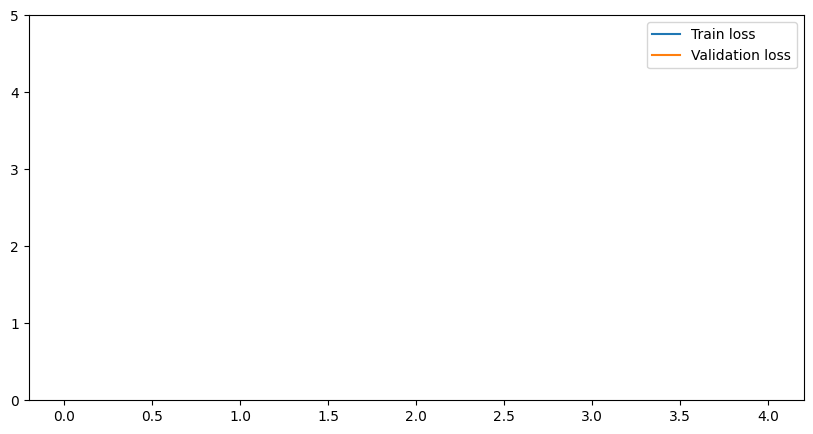

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(att_train_losses, label="Train loss")
plt.plot(att_val_losses, label="Validation loss")
plt.ylim(0, 5)
plt.legend()
plt.show()

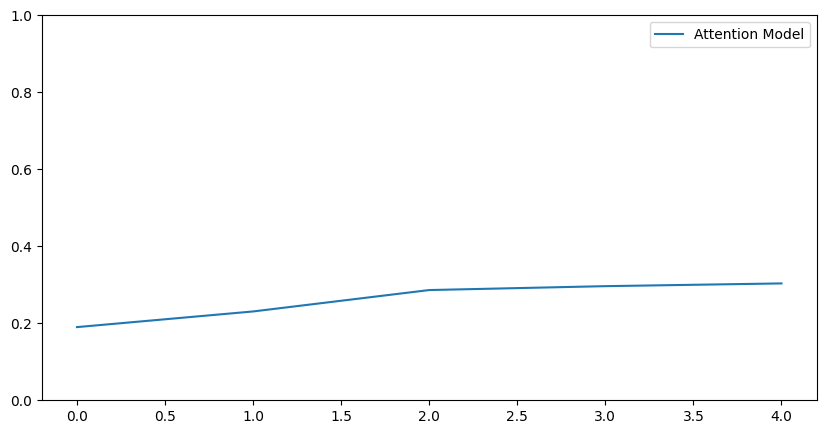

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(att_accuracies, label="Attention Model")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Testing <br>
BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is".

**BLEU's output is always a number between 0 and 1.** This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.


*Documentation:*

 - [NLTK Implementation](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 - [ SmoothingFunction](https://aclanthology.org/W14-3346.pdf)

In [17]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(labels, preds):
    labels = np.reshape(labels, (round(len(test_preds)/MAX_LEN), MAX_LEN)).tolist()
    preds = np.reshape(preds, (round(len(test_preds)/MAX_LEN), MAX_LEN)).tolist()

    bleus = []
    for ref, cand in zip(labels, preds):
        bleus.append(sentence_bleu([ref], cand, weights=[0.25, 0.25, 0.25, 0.25], smoothing_function=SmoothingFunction().method7))

    return sum(bleus)/len(bleus)


att_model.load_state_dict(torch.load(f"models/{att_model.model_name}.pth", weights_only=False))
test_preds, test_labels = att_model.generate(test_loader)

print(f"Test Accuracy for {att_model.model_name} model: {round(accuracy_score(test_labels, test_preds)*100, 2)}%")
print(f"Test BLEU Score for {att_model.model_name} model: {round(compute_bleu(test_labels, test_preds), 2)}")


Test Accuracy for attention model: 31.04%
Test BLEU Score for attention model: 0.14
